In [2]:
# Importing pandas library
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Used for pie charts in part 2
import matplotlib.pyplot as plt



# Used for plotting decision tree in part 2
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

In [3]:
# Load the data
data = pd.read_csv('https://storm.cis.fordham.edu/~afaid/Malware-staDyn-data.csv')

In [4]:
print(data.columns)
# After checking columns, we split features by label

Index(['Virtual', 'Offset', 'loc', 'Import', 'Imports', 'var', 'Forwarder',
       'UINT', 'LONG', 'BOOL',
       ...
       'count_file_written', 'count_file_exists', 'count_file_deleted',
       'count_file_copied', 'count_file_renamed', 'count_regkey_written',
       'count_regkey_deleted', 'count_file_opened', 'count_dll_loaded',
       'label'],
      dtype='object', length=1085)


In [5]:
# Split into features and target
X = data.drop('label', axis=1)
y = data['label']

In [6]:
# Defining classifiers and parameters
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=10)
knn = KNeighborsClassifier()

rf_smote_5 = RandomForestClassifier(n_estimators=5)
rf_smote_10 = RandomForestClassifier(n_estimators=10)
rf_smote_20 = RandomForestClassifier(n_estimators=20)
rf_smote_10_5 = RandomForestClassifier(n_estimators=10, max_features=5)
rf_smote_10_10 = RandomForestClassifier(n_estimators=10, max_features=10)
rf_smote_10_20 = RandomForestClassifier(n_estimators=10, max_features=20)
rf_smote_10_40 = RandomForestClassifier(n_estimators=10, max_features=40)
rf_smote_10_100 = RandomForestClassifier(n_estimators=10, max_features=100)

knn_smote_5 = KNeighborsClassifier(n_neighbors=5)
knn_smote_1 = KNeighborsClassifier(n_neighbors=1)
knn_smote_3 = KNeighborsClassifier(n_neighbors=3)
knn_smote_10 = KNeighborsClassifier(n_neighbors=10)
knn_smote_20 = KNeighborsClassifier(n_neighbors=20)

In [7]:
# Declaring sampling strategies
ros = RandomOverSampler(random_state=0)
smote = SMOTE(random_state=0)

In [8]:
# Defining experiments
experiments = [
    ('DT', 'Unbalanced', None, dt),
    ('DT', 'ROS', ros, dt),
    ('DT', 'SMOTE', smote, dt),
    ('RF', 'Unbalanced', None, rf),
    ('RF', 'SMOTE', smote, rf_smote_5),
    ('RF', 'SMOTE', smote, rf_smote_10),
    ('RF', 'SMOTE', smote, rf_smote_20),
    ('RF', 'SMOTE', smote, rf_smote_10_5),
    ('RF', 'SMOTE', smote, rf_smote_10_10),
    ('RF', 'SMOTE', smote, rf_smote_10_20),
    ('RF', 'SMOTE', smote, rf_smote_10_40),
    ('RF', 'SMOTE', smote, rf_smote_10_100),
    ('kNN', 'Unbalanced', None, dt),
    ('kNN', 'SMOTE', smote, knn_smote_5),
    ('kNN', 'SMOTE', smote, knn_smote_1),
    ('kNN', 'SMOTE', smote, knn_smote_3),
    ('kNN', 'SMOTE', smote, knn_smote_10),
    ('kNN', 'SMOTE', smote, knn_smote_20),
]

In [9]:
# Run the experiments and store the results
# Checks if sampler is defined, else it uses the original dataset and is split.
results = []
for experiment in experiments:
    name, balance, sampler, clf = experiment
    if sampler:
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    else:
        X_resampled, y_resampled = X, y
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    results.append((name, balance, clf, accuracy, auc, f1, precision, recall))

In [10]:
# Set table columns
columns = ['Algorithm', 'Balance Strategy', 'Parameters', 'Accuracy', 'AUC', 'F1-Score', 'Precision', 'Recall']
results_table = pd.DataFrame(columns=columns)

In [11]:
# Add the results to the table
# Set Paramaters and make sure to identify if they are null.
for result in results:
    name, balance, clf, accuracy, auc, f1, precision, recall = result
    if isinstance(clf, DecisionTreeClassifier):
        parameters = '-'
    elif isinstance(clf, RandomForestClassifier):
        parameters = f'{clf.n_estimators} trees, {clf.max_features} features'
    elif isinstance(clf, KNeighborsClassifier):
        parameters = f'k={clf.n_neighbors}'
    else:
        parameters = '-'
    results_table = results_table.append({'Algorithm': name, 'Balance Strategy': balance, 'Parameters': parameters, 'Accuracy': accuracy, 'AUC': auc, 'F1-Score': f1, 'Precision': precision, 'Recall': recall}, ignore_index=True)

In [12]:
# Creating a bordered table
border_style = 'solid'
border_color = 'black'
styles = [
    dict(selector='th', props=[('border', f'1px {border_style} {border_color}'), ('text-align', 'center'), ('padding', '4px')]),
    dict(selector='td', props=[('border', f'1px {border_style} {border_color}'), ('text-align', 'center'), ('padding', '4px')]),
    dict(selector='tr:nth-child(even)', props=[('background-color', '#f0f0f0')]),
    dict(selector='thead', props=[('background-color', '#ccc')]),
    dict(selector='caption', props=[('caption-side', 'bottom'), ('font-style', 'italic')])
]

# Styler object and styles
styled_table = results_table.style.set_table_styles(styles).set_caption('Malware Detection Results')

# rounding columns to display three decimal places
styled_table = styled_table.format({'Accuracy': '{:.3f}', 'AUC': '{:.3f}', 'F1-Score': '{:.3f}', 'Precision': '{:.3f}', 'Recall': '{:.3f}'})

# display styled table
styled_table

,Algorithm,Balance Strategy,Parameters,Accuracy,AUC,F1-Score,Precision,Recall
0,DT,Unbalanced,-,0.993,0.987,0.996,0.959,0.979
1,DT,ROS,-,0.997,0.997,0.997,0.995,1.000
2,DT,SMOTE,-,0.995,0.995,0.995,0.994,0.996
3,RF,Unbalanced,"10 trees, sqrt features",0.994,0.975,0.996,0.993,0.951
4,RF,SMOTE,"5 trees, sqrt features",0.994,0.994,0.994,0.996,0.993
5,RF,SMOTE,"10 trees, sqrt features",0.995,0.995,0.995,0.994,0.996
6,RF,SMOTE,"20 trees, sqrt features",0.996,0.996,0.996,0.996,0.996
7,RF,SMOTE,"10 trees, 5 features",0.995,0.995,0.995,0.992,0.998
8,RF,SMOTE,"10 trees, 10 features",0.994,0.994,0.994,0.989,0.999
9,RF,SMOTE,"10 trees, 20 features",0.996,0.996,0.996,0.991,1.000


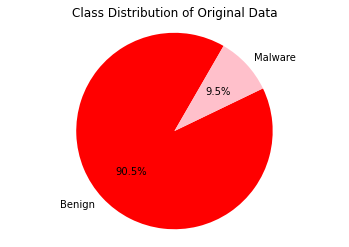

In [22]:
# Count the number of samples in each class
class_counts = data['label'].value_counts()

# Create the pie chart
labels = ['Benign', 'Malware']
colors = ['red', 'pink']
plt.pie(class_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=60)
plt.title('Class Distribution of Original Data')
plt.axis('equal')
plt.show()

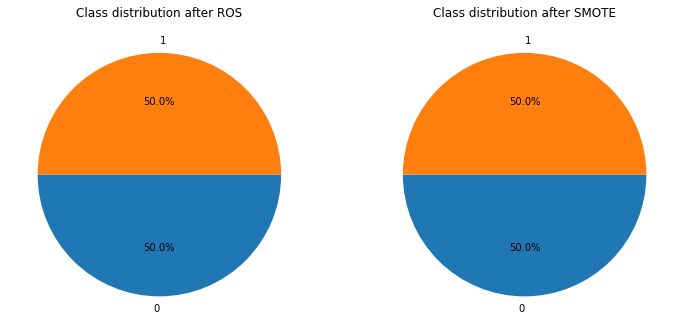

In [20]:
# Define sampling strategies
ros = RandomOverSampler(random_state=0)
smote = SMOTE(random_state=0)

# Resample the data using ROS/SMOTE
X_resampled_ros, y_resampled_ros = ros.fit_resample(X, y)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)


# Class distribution of the resampled data
counts_ros = pd.Series(y_resampled_ros).value_counts()
counts_smote = pd.Series(y_resampled_smote).value_counts()


# Plot the pie charts
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].pie(counts_ros, labels=counts_ros.index, autopct='%1.1f%%', startangle=180)
ax[0].set_title('Class distribution after ROS')
ax[1].pie(counts_smote, labels=counts_smote.index, autopct='%1.1f%%', startangle=180)
ax[1].set_title('Class distribution after SMOTE')
plt.show()

In [23]:
# Get feature importance scores
importances = rf.feature_importances_

# Create a dataframe with feature names and their importance scores
features_df = pd.DataFrame({'Features': X_train.columns, 'Importance': importances})

# Sort the dataframe by importance score in descending order
features_df = features_df.sort_values('Importance', ascending=False)

# Get the top 5 most informative features
top_5_features = list(features_df['Features'][:5])

print('Top 5 most informative features using feature importance:')
print(top_5_features)

Top 5 most informative features using feature importance:
['minor_operating_system_version', 'major_linker_version', 'size_of_stack_reserve', 'minor_image_version', 'major_image_version']


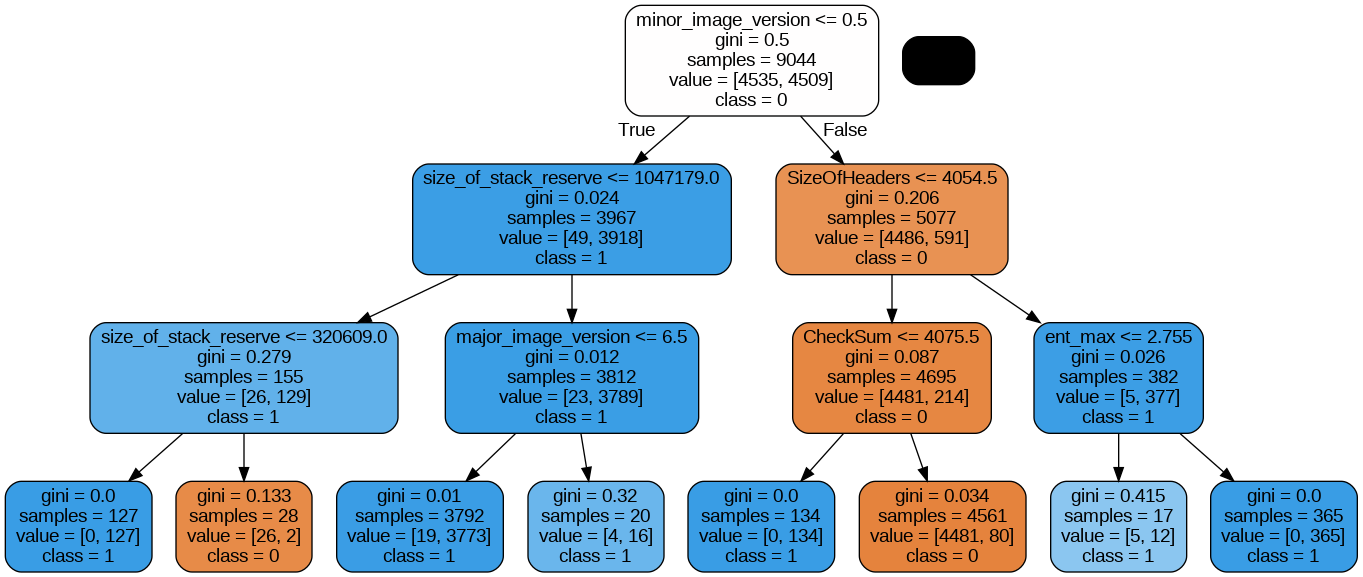

In [18]:
# Define the decision tree classifier with a maximum depth of 3
dt = DecisionTreeClassifier(max_depth=3)

# Fit the model on the resampled data
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
dt.fit(X_train, y_train)

# Generate the graph
dot_data = export_graphviz(dt, out_file=None, filled=True, rounded=True,
                                feature_names=X.columns.values, class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show the decision tree
Image(graph.create_png())

I found the number of imported DLLs feature counts and the number of external libraries that the malware program imports to be quite important. Malware relies on external libraries to perform various functions, such as stealing data or executing backdoor commands, so the number of imported DLLs can be a good indicator of the maliciousness of a program.

The number of sections feature counts the number of distinct sections in the malware program's binary file. Each section contains a specific type of data, such as code or resources. Threat actors may use additional sections to store malicious code or data that they want to hide from analysis. Therefore, the number of sections can be another useful indicator of whether a program is malicious or not.